In [1]:
import os
import numpy as np

from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from config import PDEConfig

%matplotlib inline

### Multigrid Preconditioned Sparse Iterative Solver
This notebook shows a PDE solving example with the sparse iterative solver. The sparse solver is useful for larger grids, uses less memory but is slower than the dense solver.
The solver can solve batches of linear PDEs over a grid.

We use the transport equation.

### Transport Equation

$$ \partial_t u + \partial_x u = 0


In [2]:
import torch
from solver.multigrid import MultigridLayer

bs = 5
coord_dims = (8,512)
n_ind_dim=1

We use a spatial grid of 64 steps and solve for 8 time steps at a time. We solve a batch of 5 PDEs in parallel. In this case we solve the same PDE with different initial conditions. In general they can be completely different PDEs.

### Initial Value Coordinates
The following sets the coordinates in the grid over which the initial values are given.

For nt time and nx space steps we give a 4-tuple. The first is index of the coordinate that is fixed. The second specifies the index from [$u, u_t, u_x, u_{tt}, u_{xx}$] for which the conditon is defined. The third gives the initial range for all coordinates and the last gives the final range (inclusive).


In [3]:

iv_list = [lambda nt, nx: (0,0, [0,0],[0,nx-1]),] 
        

### Initialize dense solver layer

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#pde = PDEINDLayerEPS(bs=bs, coord_dims=coord_dims, order=2, n_ind_dim=n_ind_dim, n_iv=1, 
pde = MultigridLayer(bs=bs, coord_dims=coord_dims, order=2, n_ind_dim=n_ind_dim, n_iv=1, 
#pde = PDEDenseLayer(bs=bs, coord_dims=coord_dims, order=2, n_ind_dim=n_ind_dim, n_iv=1, 
                n_grid=6, downsample_first=False,
                init_index_mi_list=iv_list,  n_iv_steps=1, double_ret=True, solver_dbl=True)



Using double precision solver
Multigrid: num grid  6
Using double precision solver
multigrid dimension list [(8, 512), (8, 256), (8, 128), (8, 64), (8, 32), (8, 16)]
mi list ((0, 0), (1, 0), (0, 1), (2, 0), (0, 2))
Constraints Shape eq torch.Size([3570, 20480]), init torch.Size([512, 20480]), deriv torch.Size([31728, 20480])
Building block diagonal A
Initial/boundary Constraints shape  torch.Size([5, 512, 20480])


/nfs/scistore19/locatgrp/apervez/work/mech-nn-dev/solver/lp_pde_central_diff.py:1252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.derivative_row_sorted = torch.tensor(row_sorted)
/nfs/scistore19/locatgrp/apervez/work/mech-nn-dev/solver/lp_pde_central_diff.py:1253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.derivative_column_sorted = torch.tensor(column_sorted)
/nfs/scistore19/locatgrp/apervez/work/mech-nn-dev/solver/lp_pde_central_diff.py:1265: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.eq_row_sorted = torch.tensor(

mi list ((0, 0), (1, 0), (0, 1), (2, 0), (0, 2))
Constraints Shape eq torch.Size([1778, 10240]), init torch.Size([256, 10240]), deriv torch.Size([15856, 10240])
Building block diagonal A
Initial/boundary Constraints shape  torch.Size([5, 256, 10240])
mi list ((0, 0), (1, 0), (0, 1), (2, 0), (0, 2))
Constraints Shape eq torch.Size([882, 5120]), init torch.Size([128, 5120]), deriv torch.Size([7920, 5120])
Building block diagonal A
Initial/boundary Constraints shape  torch.Size([5, 128, 5120])
mi list ((0, 0), (1, 0), (0, 1), (2, 0), (0, 2))
Constraints Shape eq torch.Size([434, 2560]), init torch.Size([64, 2560]), deriv torch.Size([3952, 2560])
Building block diagonal A
Initial/boundary Constraints shape  torch.Size([5, 64, 2560])
mi list ((0, 0), (1, 0), (0, 1), (2, 0), (0, 2))
Constraints Shape eq torch.Size([210, 1280]), init torch.Size([32, 1280]), deriv torch.Size([1968, 1280])
Building block diagonal A
Initial/boundary Constraints shape  torch.Size([5, 32, 1280])
mi list ((0, 0), (

### Specify step sizes

In [ ]:
t_step_size = 0.005 #2*np.pi/coord_dims[0]
x_step_size = 2*np.pi/coord_dims[1]


steps0 = torch.logit(t_step_size*torch.ones(1,1)).to(device)
steps1 = torch.logit(x_step_size*torch.ones(1,1)).to(device)

steps0 = steps0.expand(-1, coord_dims[0]-1)
steps1 = steps1.expand(-1, coord_dims[1]-1)
steps0 = torch.sigmoid(steps0)
steps1 = torch.sigmoid(steps1)

# use the same step sizes over the batch
steps0 = torch.stack([steps0]*bs,dim=0)
steps1 = torch.stack([steps1]*bs,dim=0)
steps_list = [steps0, steps1]

### PDE Coefficients
PDE coefficients are defined over the entire spatio-temporal grid for each term. The defined terms are $u, u_t, u_x, u_{tt}, u_{xx}$ in that order.

In [6]:

coeffs = torch.zeros((bs, pde.grid_size, pde.n_orders), device=device)
#u, u_t, u_x, u_tt, u_xx
#u_t + u_x = 0
coeffs[..., 0] = 0.
coeffs[..., 1] = 1.
coeffs[..., 2] = 1.
coeffs[..., 3] = 0.
#u_xx
coeffs[..., 4] = 0.


### Source Term

Define the right hand side (source term) also over the grid.

In [7]:

rhs = torch.zeros(bs, *coord_dims, device=device)


### Initial values

In [8]:

#iv
x_steps = torch.linspace(0, 2*np.pi, coord_dims[1], device=device)


In [9]:
iv_list = []

for i in range(bs):
    iv = torch.sin((i+1)/2*x_steps) 
    iv_list.append(iv)
#y_bc = torch.sin(y_steps) 


u_list = []
iv_rhs = torch.stack(iv_list,dim=0)


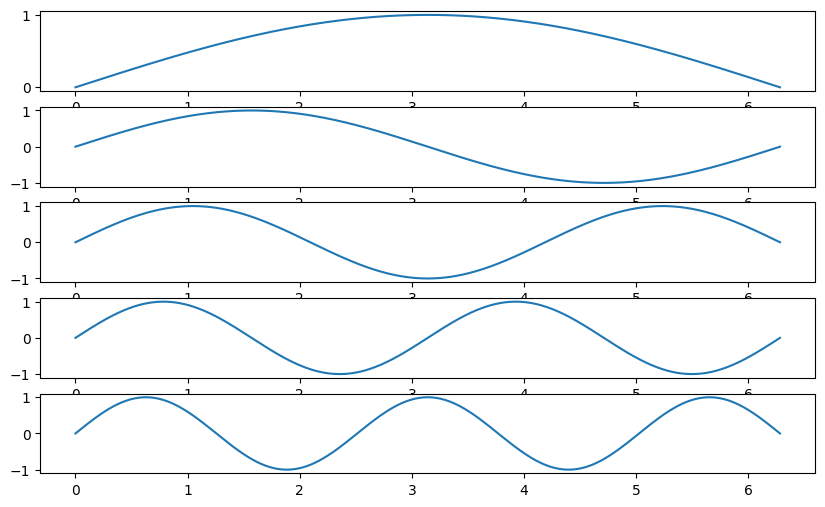

In [10]:

f, axs = plt.subplots(bs, figsize=(10,6))
for i in range(bs): 
    axs[i].plot(np.array(x_steps.cpu()), np.array(iv_rhs[i].cpu()))

Modify solver parameters to balance accuracy and time.

In [11]:

# multigrid options
PDEConfig.mg_gauss_seidel_steps_pre = 5
PDEConfig.mg_gauss_seidel_steps_post =5

PDEConfig.mg_steps_forward  = 1

PDEConfig.mg_fgmres_max_iter_forward = 40
PDEConfig.mg_fgmres_restarts_forward = 20


In [12]:
# march forward in time in steps of 8
for i in range(5):
    u0,_,eps = pde(coeffs, rhs, iv_rhs, steps_list)
    
    u0 = u0.reshape(bs,*coord_dims)
    iv_rhs = u0[:, -1]
    u_list.append(u0)

u0 = torch.cat(u_list, dim=1)


gmres step norm: tensor([0.0003, 0.0003, 0.0008, 0.0015, 0.0025], device='cuda:0',
       dtype=torch.float64),tensor([2.0714e-05, 2.1571e-05, 5.0437e-05, 9.5781e-05, 1.5357e-04],
       device='cuda:0', dtype=torch.float64)
qpf torch.Size([5, 20480])
gmres step norm: tensor([0.0002, 0.0003, 0.0007, 0.0012, 0.0021], device='cuda:0',
       dtype=torch.float64),tensor([1.4597e-05, 1.5984e-05, 4.2215e-05, 7.6783e-05, 1.3222e-04],
       device='cuda:0', dtype=torch.float64)
qpf torch.Size([5, 20480])
gmres step norm: tensor([0.0002, 0.0004, 0.0006, 0.0011, 0.0019], device='cuda:0',
       dtype=torch.float64),tensor([1.2845e-05, 2.2544e-05, 3.9134e-05, 7.1851e-05, 1.1862e-04],
       device='cuda:0', dtype=torch.float64)
qpf torch.Size([5, 20480])
gmres step norm: tensor([0.0002, 0.0003, 0.0007, 0.0012, 0.0018], device='cuda:0',
       dtype=torch.float64),tensor([9.9795e-06, 1.7151e-05, 4.2117e-05, 7.3821e-05, 1.1229e-04],
       device='cuda:0', dtype=torch.float64)
qpf torch.Size([5, 

In [114]:
u0.shape

torch.Size([5, 64, 128])

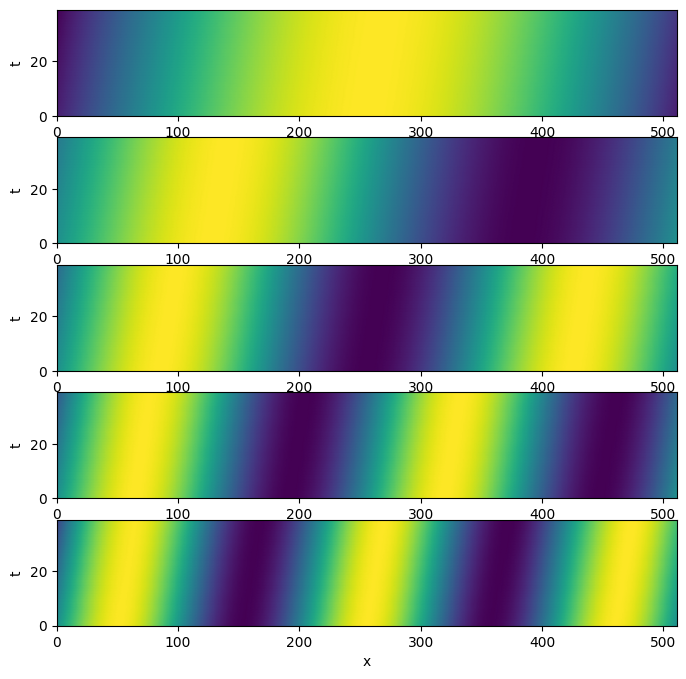

In [13]:
u0p = u0.detach().cpu().numpy()

f, axs = plt.subplots(bs, figsize=(8, 8))
# %%
for i in range(bs):
    axs[i].pcolormesh(u0p[i], cmap='viridis', shading='gouraud')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('t')

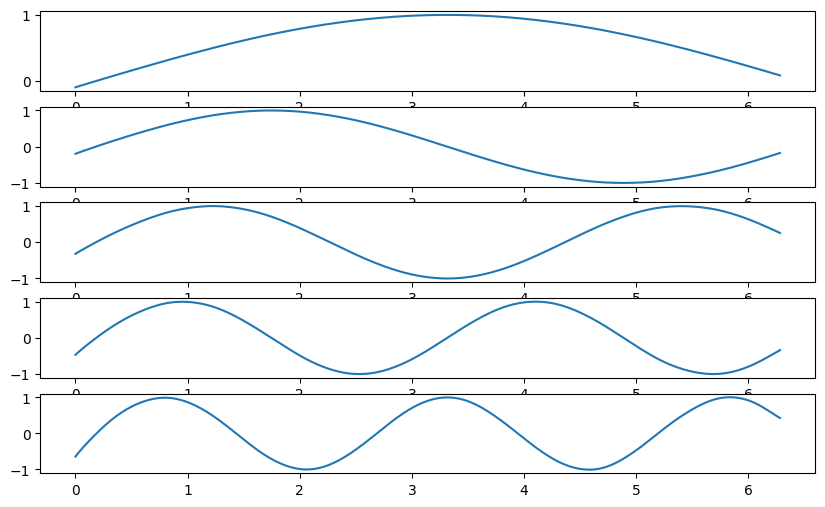

In [14]:
### Final solution

f, axs = plt.subplots(bs, figsize=(10,6))
for i in range(bs): 
    axs[i].plot(np.array(x_steps.cpu()),u0p[i, -1])